In [ ]:
import kagglehub
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/mrmorj/hate-speech-and-offensive-language-dataset/versions/1


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import re


In [30]:
dataset = pd.read_csv("/home/jovyan/.cache/kagglehub/datasets/mrmorj/hate-speech-and-offensive-language-dataset/versions/1/labeled_data.csv", index_col=0)

In [31]:
dataset.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [32]:
# Check misisng value
dataset.isnull().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [34]:
print(dataset.columns)

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')


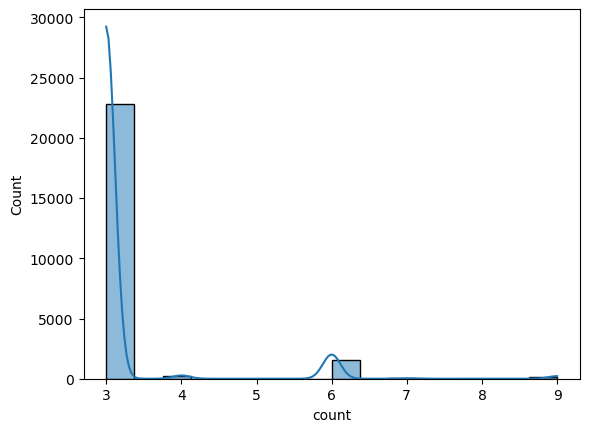

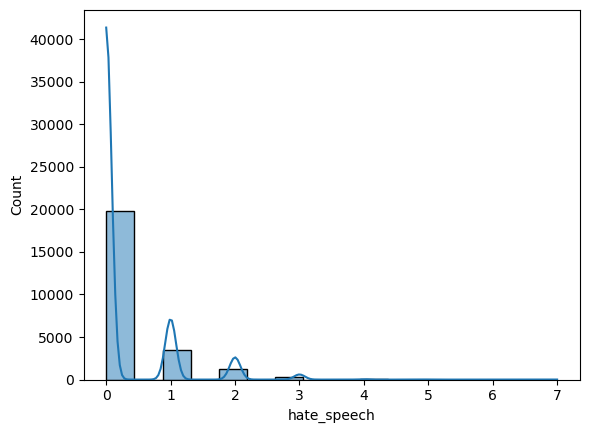

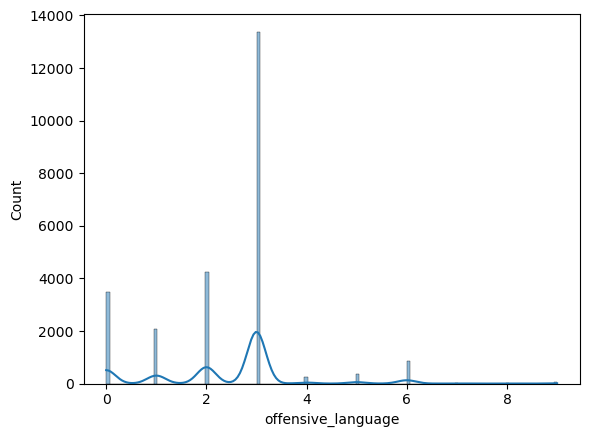

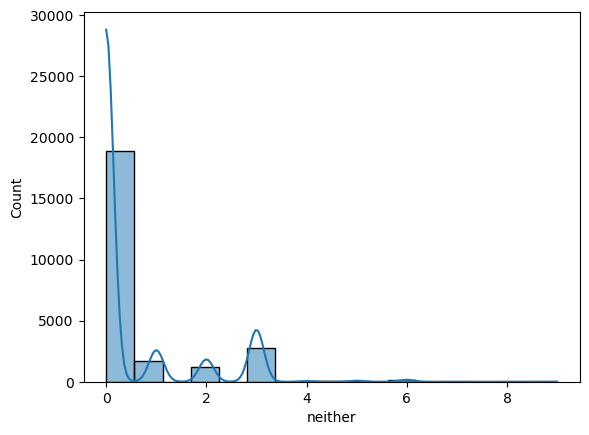

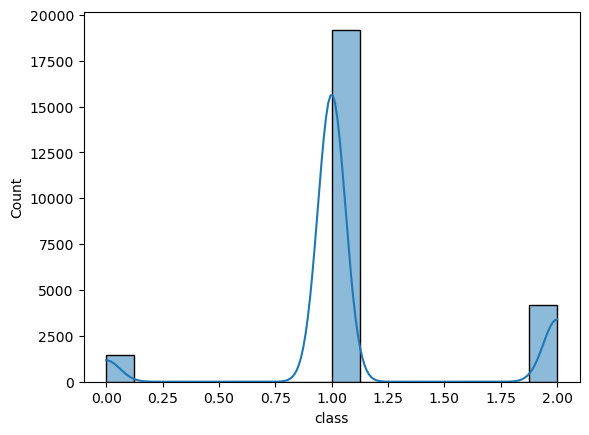

In [35]:
columns = ['count', 'hate_speech', 'offensive_language', 'neither', 'class']
for i in range(len(dataset.columns) -1):
    sns.histplot(dataset[columns[i]], kde=True)
    plt.show()

In [36]:

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)        # remove URLs
    text = re.sub(r"@\w+", "", text)           # remove mentions
    text = re.sub(r"[!?]+", "", text)          # remove ! and ?
    text = re.sub(r"\s+", " ", text).strip()   # remove extra spaces
    return text

dataset["clean_tweet"] = dataset["tweet"].apply(clean_tweet)

In [37]:
dataset["clean_tweet"]

0        rt : as a woman you shouldn't complain about c...
1        rt : boy dats cold...tyga dwn bad for cuffin d...
2        rt dawg rt : you ever fuck a bitch and she sta...
3                              rt : she look like a tranny
4        rt : the shit you hear about me might be true ...
                               ...                        
25291    you's a muthaf***in lie &#8220;: right his tl ...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat.. dat nigguh like i aint ...
25295                youu got wild bitches tellin you lies
25296    ~~ruffled | ntac eileen dahlia - beautiful col...
Name: clean_tweet, Length: 24783, dtype: object

In [38]:
# Tokenizer all the input
tokenizer = Tokenizer(num_words=200, oov_token="<OOV>")
tokenizer.fit_on_texts(dataset["clean_tweet"])
dataset["sequences"] = tokenizer.texts_to_sequences(dataset["clean_tweet"])

In [39]:
dataset.head()

,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet,sequences
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt : as a woman you shouldn't complain about c...,"[5, 79, 2, 1, 7, 1, 1, 62, 1, 33, 31, 1, 61, 7..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt : boy dats cold...tyga dwn bad for cuffin d...,"[5, 1, 1, 1, 1, 1, 87, 24, 1, 164, 26, 14, 6, ..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt : you ever fuck a bitch and she sta...,"[5, 1, 5, 7, 182, 39, 2, 3, 9, 51, 1, 8, 1, 7,..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt : she look like a tranny,"[5, 51, 100, 16, 2, 1]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt : the shit you hear about me might be true ...,"[5, 6, 48, 7, 1, 62, 17, 1, 21, 1, 77, 25, 1, ..."


In [40]:
dataset = dataset.drop(["tweet","clean_tweet"], axis=1)

In [41]:
X = pad_sequences(dataset["sequences"], padding='post', maxlen=100)
y = dataset["class"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [42]:
model = Sequential([
    Embedding(input_dim=200, output_dim=128, input_length=200),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
dataset.head()

,count,hate_speech,offensive_language,neither,class,sequences
0,3,0,0,3,2,"[5, 79, 2, 1, 7, 1, 1, 62, 1, 33, 31, 1, 61, 7..."
1,3,0,3,0,1,"[5, 1, 1, 1, 1, 1, 87, 24, 1, 164, 26, 14, 6, ..."
2,3,0,3,0,1,"[5, 1, 5, 7, 182, 39, 2, 3, 9, 51, 1, 8, 1, 7,..."
3,3,0,2,1,1,"[5, 51, 100, 16, 2, 1]"
4,6,0,6,0,1,"[5, 6, 48, 7, 1, 62, 17, 1, 21, 1, 77, 25, 1, ..."


In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

batch_size = 128

model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=batch_size, epochs=10)


Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7440 - loss: 0.7081 - val_accuracy: 0.8698 - val_loss: 0.3669
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8668 - loss: 0.3725 - val_accuracy: 0.8717 - val_loss: 0.3546
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8757 - loss: 0.3559 - val_accuracy: 0.8786 - val_loss: 0.3413
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8780 - loss: 0.3411 - val_accuracy: 0.8777 - val_loss: 0.3358
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8788 - loss: 0.3337 - val_accuracy: 0.8765 - val_loss: 0.3300
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8774 - loss: 0.3261 - val_accuracy: 0.8790 - val_loss: 0.3232
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8818 - loss: 0.3143 - val_accuracy: 0.8780 - val_loss: 0.3239
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8802 - loss: 0.3186 - val_accu

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,435 (1.92 MB)

 Trainable params: 167,811 (655.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 335,624 (1.28 MB)